In [112]:
import numpy as np
 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Hyper-parameters

In [113]:
n_epochs = 1000
batch_size = 32
learning_rate = 1e-3
weight_decay=0
embedding_dim = 8
momentum = 0
gamma = 0.01 # ratio between reconstruction loss & regression loss

train_data_ratio = 0.8 # if 0.7 then train:test = 70:30 when randomly split it

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data & Pre-processing

In [114]:
class Make_Dataset(Dataset):
 
  def __init__(self,x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

In [115]:
### Load Data ###

CCesc2i_Meta = pd.read_table('data/CellCycle/CCesc2i_Meta.txt')
CCesc2i_counts = pd.read_table('data/CellCycle/CCesc2i_counts.txt')
CCesc2i_sampleinfo = pd.read_table('data/CellCycle/CCesc2i_sampleinfo.txt')
CCescSerum_Meta = pd.read_table('data/CellCycle/CCescSerum_Meta.txt')
CCescSerum_counts = pd.read_table('data/CellCycle/CCescSerum_counts.txt')
CCescSerum_sampleinfo = pd.read_table('data/CellCycle/CCescSerum_sampleinfo.txt')

DTesc2i_Meta = pd.read_table('data/DrugTreatment/DTesc2i_Meta.txt')
DTesc2i_tpm = pd.read_table('data/DrugTreatment/DTesc2i_tpm.txt')
DTesc2i_sampleinfo = pd.read_table('data/DrugTreatment/DTesc2i_sampleinfo.txt')
DTescSerum_Meta = pd.read_table('data/DrugTreatment/DTescSerum_Meta.txt')
DTescSerum_tpm = pd.read_table('data/DrugTreatment/DTescSerum_tpm.txt')
DTescSerum_sampleinfo = pd.read_table('data/DrugTreatment/DTescSerum_sampleinfo.txt')

### re-arrange count matrix ###

CCesc2i_counts = CCesc2i_counts.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
CCesc2i_counts.columns.name = None
CCescSerum_counts = CCescSerum_counts.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
CCescSerum_counts.columns.name = None
DTesc2i_tpm = DTesc2i_tpm.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
DTesc2i_tpm.columns.name = None
DTescSerum_tpm = DTescSerum_tpm.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
DTescSerum_tpm.columns.name = None

### Inner Join three tables (Meta data, count matrix, sample info) ###

merged_CCesc2i = pd.merge(left=CCesc2i_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=CCesc2i_counts, left_on='Counts_identifier', right_on='Name')
merged_CCesc2i = pd.merge(left=CCesc2i_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_CCesc2i, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_CCescSerum = pd.merge(left=CCescSerum_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=CCescSerum_counts, left_on='Counts_identifier', right_on='Name')
merged_CCescSerum = pd.merge(left=CCescSerum_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_CCescSerum, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_DTesc2i = pd.merge(left=DTesc2i_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=DTesc2i_tpm, left_on='Counts_identifier', right_on='Name')
merged_DTesc2i = pd.merge(left=DTesc2i_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_DTesc2i, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_DTescSerum = pd.merge(left=DTescSerum_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=DTescSerum_tpm, left_on='Counts_identifier', right_on='Name')
merged_DTescSerum = pd.merge(left=DTescSerum_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_DTescSerum, left_on='Unnamed: 0', right_on='Counts_identifier')

### process data ###

# Keep only percent_mapped > 40%
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i.percent_mapped <= 40].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum.percent_mapped <= 40].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i.percent_mapped <= 40].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum.percent_mapped <= 40].index)

# Remove cell name "888"
# skip this action because couldn't find any cells contain name of '888'

# Remove cells with negative values in meta data
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['mVenus_A'] < 0].index)
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['mCherry_A'] < 0].index)
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['Hoechst_A'] < 0].index)

merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['mVenus_A'] < 0].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['mCherry_A'] < 0].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['Hoechst_A'] < 0].index)

merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['mVenus_A'] < 0].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['mCherry_A'] < 0].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['Hoechst_A'] < 0].index)

merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['mVenus_A'] < 0].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['mCherry_A'] < 0].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['Hoechst_A'] < 0].index)

# further process: drop unused columns
CCesc2i = merged_CCesc2i.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
CCescSerum = merged_CCescSerum.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
DTesc2i = merged_DTesc2i.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
DTescSerum = merged_DTescSerum.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})

# select UT condition from DT dataset
DTesc2i_UT = DTesc2i[DTesc2i["Name"].str.contains('UT')]
DTescSerum_UT = DTescSerum[DTescSerum["Name"].str.contains('UT')]

# Concat CC + DT_UT Data
CCesc2i_DTesc2i_UT = pd.concat([CCesc2i, DTesc2i_UT])
CCescSerum_DTescSerum_UT = pd.concat([CCescSerum, DTescSerum_UT])

# Concat all conditions
df_total = pd.concat([CCesc2i, CCescSerum, DTesc2i, DTescSerum])

In [116]:
# dataframe to numpy
np_features = CCesc2i_DTesc2i_UT.iloc[:, 4:].values
np_targets = CCesc2i_DTesc2i_UT.iloc[:, 1:4].values

# log normalization
np_features_diff = np_features - np.min(np_features, axis=0)
np_features = np.log(np_features + 0.001)

np_targets = np_targets - np.min(np_targets, axis=0)
np_targets = np.log(np_targets + 0.00001)

# data normalization
np_features = minmax_scaler.fit_transform(np_features)
np_targets = minmax_scaler.fit_transform(np_targets)

distance_features = np.linalg.norm(np_features - np.mean(np_features, axis=0), axis=1)
distance_targets = np.linalg.norm(np_targets - np.mean(np_targets, axis=0), axis=1)

# remove outliers
index_feature_outliers = distance_features > np.min(distance_features) + 6*np.std(distance_features)
index_target_outliers = distance_targets > np.min(distance_targets) + 4*np.std(distance_targets)
index_outliers = np.logical_or(index_feature_outliers, index_target_outliers)
index = np.logical_not(index_outliers)
np_features = np_features[index]
np_targets = np_targets[index]

print(np.sum(index_feature_outliers))
print(np.sum(index_target_outliers))

cutoff_distance_features = np.linalg.norm(np_features - np.mean(np_features, axis=0), axis=1)
cutoff_distance_targets = np.linalg.norm(np_targets - np.mean(np_targets, axis=0), axis=1)

# convert to tensors
features = torch.tensor(np_features.astype(np.float32))
targets = torch.tensor(np_targets.astype(np.float32))

dataset = Make_Dataset(features, targets)
train_size = int(train_data_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

5
3


In [117]:
def plot_data_distribution(data, title=None):
    plt.figure(figsize=(25, 3))
    if title is not None:
        plt.title(title)
    plt.plot(data, 'o')
    plt.show()

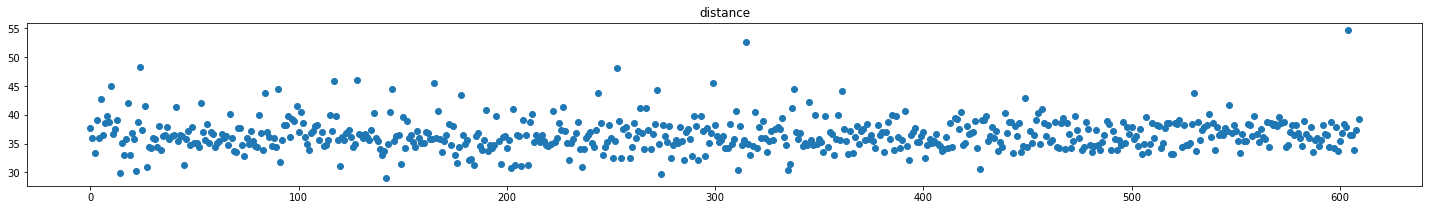

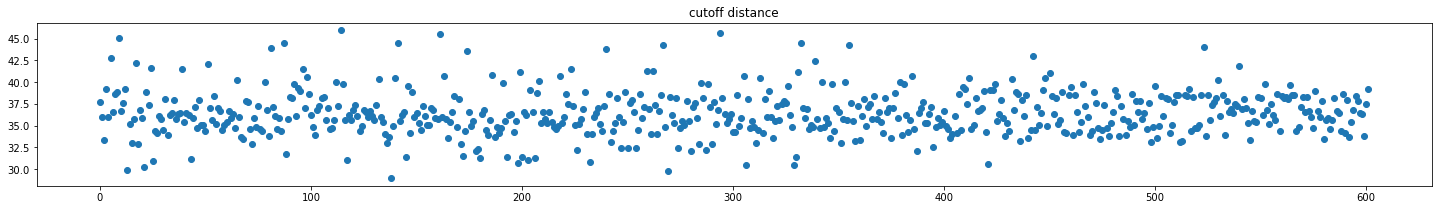

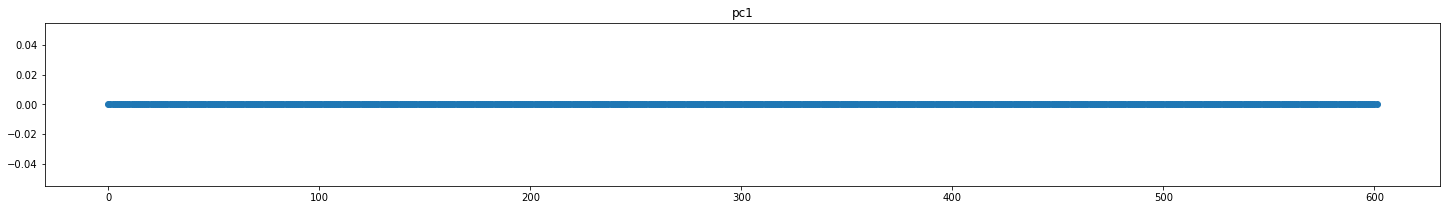

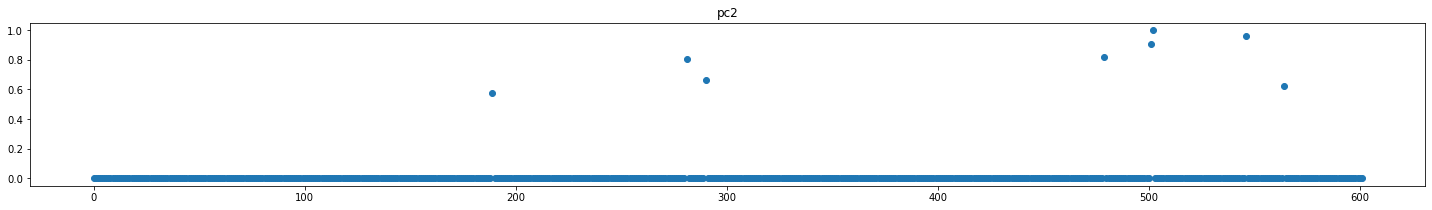

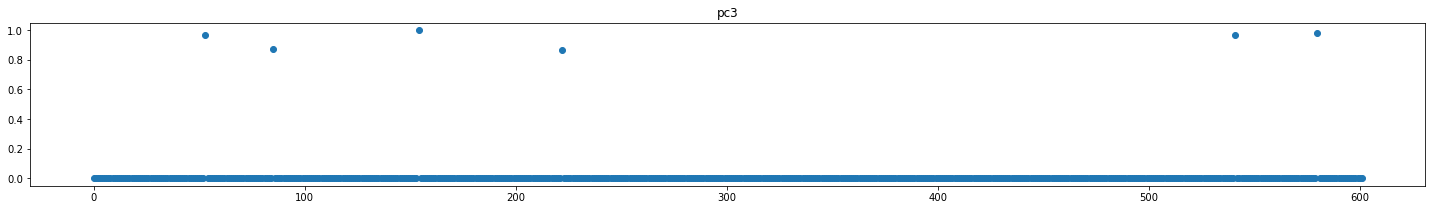

In [118]:
plot_data_distribution(distance_features, title='distance')
plot_data_distribution(cutoff_distance_features, title='cutoff distance')

for i in range(np_features.shape[1] if np_features.shape[1] < 3 else 3):
    plot_data_distribution(np_features[:, i], title='pc{}'.format(i+1))

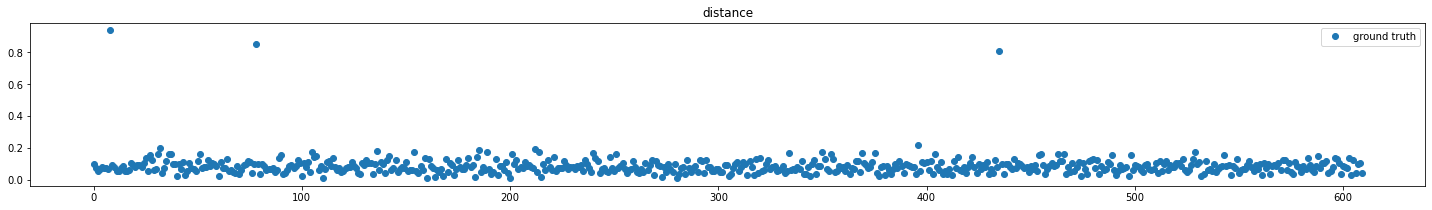

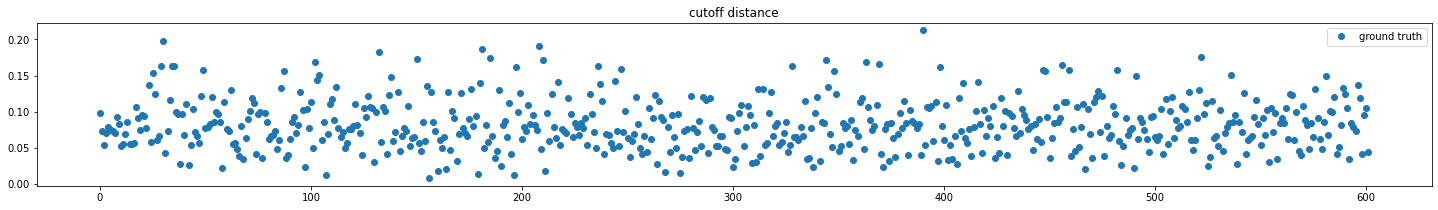

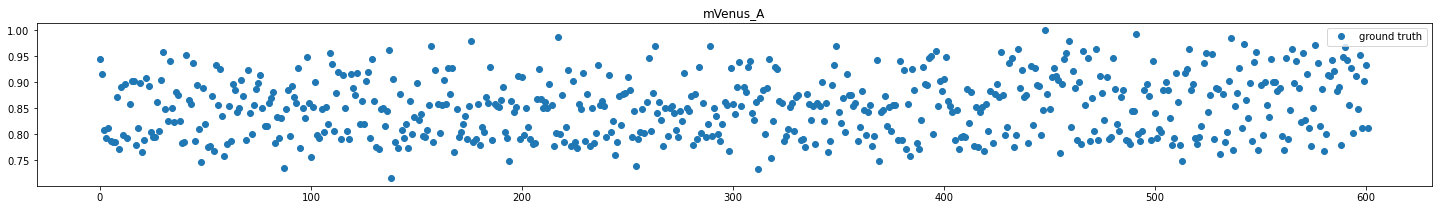

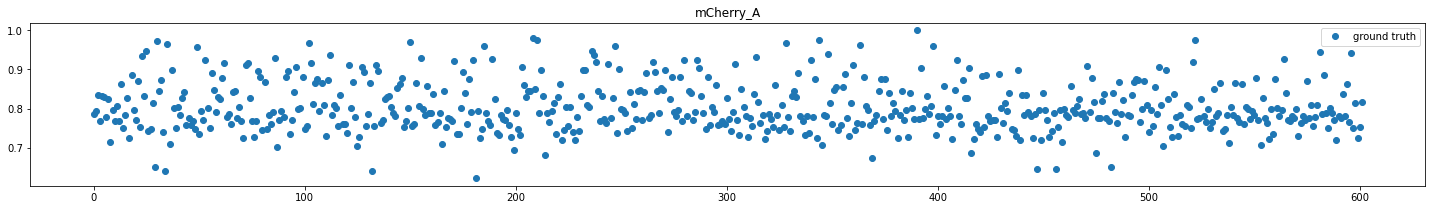

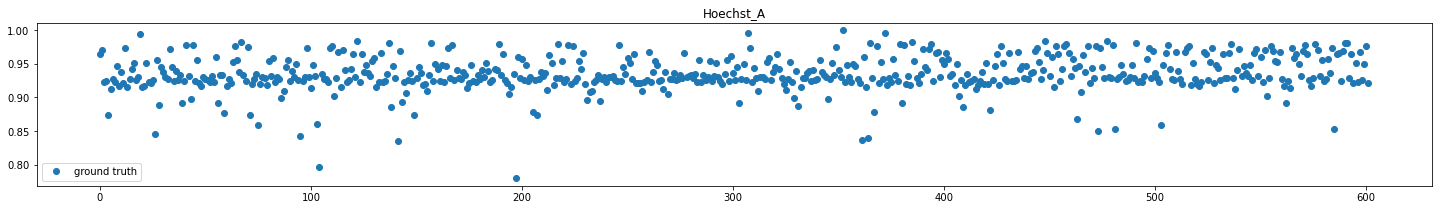

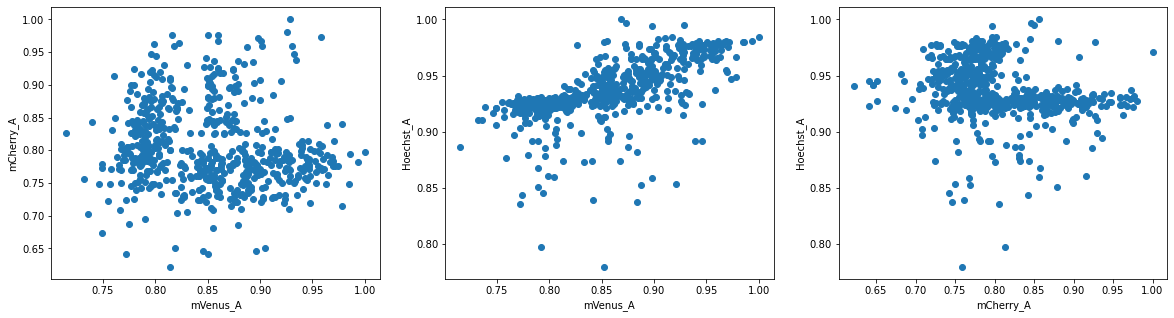

In [119]:
plt.figure(figsize=(25, 3))
plt.title('distance')
plt.plot(distance_targets, 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('cutoff distance')
plt.plot(cutoff_distance_targets, 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(np_targets[:, 0], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(np_targets[:, 1], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(np_targets[:, 2], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(np_targets[:, 0], np_targets[:, 1])
plt.xlabel('mVenus_A')
plt.ylabel('mCherry_A')

plt.subplot(1, 3, 2)
plt.scatter(np_targets[:, 0], np_targets[:, 2])
plt.xlabel('mVenus_A')
plt.ylabel('Hoechst_A')

plt.subplot(1, 3, 3)
plt.scatter(np_targets[:, 1], np_targets[:, 2])
plt.xlabel('mCherry_A')
plt.ylabel('Hoechst_A')
plt.show()



In [120]:
print('CCesc2i_Meta size: {}'.format(CCesc2i_Meta.shape))
print('DTesc2i_Meta size: {}'.format(DTesc2i_Meta.shape))
print()
print('CCesc2i_counts size: {}'.format(CCesc2i_counts.shape))
print('DTesc2i_tpm size: {}'.format(DTesc2i_tpm.shape))
print()
print('merged_CCesc2i size: {}'.format(merged_CCesc2i.shape))
print('merged_DTesc2i size: {}'.format(merged_DTesc2i.shape))
print()
print('CCesc2i size: {}'.format(CCesc2i.shape))
print('DTesc2i size: {}'.format(DTesc2i.shape))
print()
print('DTesc2i_UT size: {}'.format(DTesc2i_UT.shape))
print()
print('CCesc2i_DTesc2i_UT size: {}'.format(CCesc2i_DTesc2i_UT.shape))
print('df_total size: {}'.format(df_total.shape))
print()
print('dataset size: {}'.format(len(dataset)))
print('train_dataset size: {}'.format(len(train_dataset)))
print('test_dataset size: {}'.format(len(test_dataset)))
print('feature_dim={} targets_dim={}'.format(features.shape[1], targets.shape[1]))
print()


CCesc2i_Meta size: (430, 30)
DTesc2i_Meta size: (541, 21)

CCesc2i_counts size: (485, 49194)
DTesc2i_tpm size: (581, 49194)

merged_CCesc2i size: (430, 49200)
merged_DTesc2i size: (536, 49200)

CCesc2i size: (430, 49197)
DTesc2i size: (536, 49197)

DTesc2i_UT size: (180, 49197)

CCesc2i_DTesc2i_UT size: (610, 49197)
df_total size: (1892, 49197)

dataset size: 602
train_dataset size: 481
test_dataset size: 121
feature_dim=49193 targets_dim=3



# Define Network

In [121]:
class Network(nn.Module):

    def __init__(self, input_dim=29873, output_dim=4, embedding_dim=2):
        super(Network, self).__init__()

        n_layers = 3
        interval = (embedding_dim - output_dim) / n_layers

        self.encoder_linear1 = nn.Linear(input_dim, embedding_dim * 4)
        self.encoder_linear2 = nn.Linear(embedding_dim * 4, embedding_dim * 2)
        self.encoder_linear3 = nn.Linear(embedding_dim * 2, embedding_dim)

        self.decoder_linear1 = nn.Linear(embedding_dim + self.encoder_linear2.out_features, embedding_dim * 2)
        self.decoder_linear2 = nn.Linear(embedding_dim * 2 + self.encoder_linear1.out_features, embedding_dim * 4)
        self.decoder_linear3 = nn.Linear(embedding_dim * 4, input_dim)

        self.prediction_linear1 = nn.Linear(embedding_dim, int(embedding_dim - interval))
        self.prediction_linear2 = nn.Linear(self.prediction_linear1.out_features, int(embedding_dim - 2*interval))
        self.prediction_linear3 = nn.Linear(self.prediction_linear2.out_features, output_dim)

        self.encoder_batch_norm1 = nn.BatchNorm1d(self.encoder_linear1.out_features)
        self.encoder_batch_norm2 = nn.BatchNorm1d(self.encoder_linear2.out_features)
        self.encoder_batch_norm3 = nn.BatchNorm1d(self.encoder_linear3.out_features)

        self.decoder_batch_norm1 = nn.BatchNorm1d(self.decoder_linear1.out_features)
        self.decoder_batch_norm2 = nn.BatchNorm1d(self.decoder_linear2.out_features)
        self.decoder_batch_norm3 = nn.BatchNorm1d(self.decoder_linear3.out_features)

        self.prediction_batch_norm1 = nn.BatchNorm1d(self.prediction_linear1.out_features)
        self.prediction_batch_norm2 = nn.BatchNorm1d(self.prediction_linear2.out_features)
        self.prediction_batch_norm3 = nn.BatchNorm1d(self.prediction_linear3.out_features)

        self.dropout_hidden = nn.Dropout(0)
        self.dropout_input = nn.Dropout(0)
        self.dropout_output = nn.Dropout(0)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        pass

    def forward(self, x):
        # U-Net architecture for Autoencoder

        # encoder
        x1 = self.leakyrelu(self.encoder_linear1(x))
        x2 = self.leakyrelu(self.encoder_linear2(x1))
        x3 = self.leakyrelu(self.encoder_linear3(x2))
        encoded = x3

        # decoder
        y_reconst = self.leakyrelu(self.decoder_linear1(torch.cat([x3, x2], dim=1))) # skip-connection
        y_reconst = self.leakyrelu(self.decoder_linear2(torch.cat([y_reconst, x1], dim=1))) # skip-connection
        y_reconst = self.sigmoid(self.decoder_linear3(y_reconst))

        # prediction network
        y_reg = self.leakyrelu(self.prediction_linear1(encoded))
        y_reg = self.leakyrelu(self.prediction_linear2(y_reg))
        y_reg = self.sigmoid(self.prediction_linear3(y_reg))

        return encoded, y_reconst, y_reg

In [122]:
network = Network(input_dim=np_features.shape[1], output_dim=np_targets.shape[1], embedding_dim=embedding_dim).to(device)
print(network)
print()

param_count = sum(p.numel() for p in network.parameters())
print('Number of Learnable Parameters: {}'.format(param_count))
print()

# data loader
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate / 100, max_lr=learning_rate,step_size_up=5,mode="triangular2")
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

reconstruction_losses = []
reconstruction_losses_std = []
regression_losses = []
regression_losses_std = []
train_losses = []
train_losses_std = []
test_losses = [] # regression loss of test data
test_losses_std = [] # regression loss of test data

best_model = copy.deepcopy(network)
lowest_test_loss = 99999

Network(
  (encoder_linear1): Linear(in_features=49193, out_features=32, bias=True)
  (encoder_linear2): Linear(in_features=32, out_features=16, bias=True)
  (encoder_linear3): Linear(in_features=16, out_features=8, bias=True)
  (decoder_linear1): Linear(in_features=24, out_features=16, bias=True)
  (decoder_linear2): Linear(in_features=48, out_features=32, bias=True)
  (decoder_linear3): Linear(in_features=32, out_features=49193, bias=True)
  (prediction_linear1): Linear(in_features=8, out_features=6, bias=True)
  (prediction_linear2): Linear(in_features=6, out_features=4, bias=True)
  (prediction_linear3): Linear(in_features=4, out_features=3, bias=True)
  (encoder_batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_batch_norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_batch_norm3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_batch_norm

In [123]:
print('Train Start')

for epoch in range(n_epochs):

    network.train()

    reconstruction_losses_epoch = []
    regression_losses_epoch = []
    train_losses_epoch = []
    test_losses_epoch = []

    for x, y in train_data_loader:

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        _, reconstructed, pred = network(x)
        loss_reconst = l1_loss(reconstructed, x)
        loss_reg = mse_loss(pred, y)
        total_loss = loss_reconst + gamma * loss_reg
        total_loss.backward()
        optimizer.step()

        reconstruction_losses_epoch.append(loss_reconst.item())
        regression_losses_epoch.append(loss_reg.item())
        train_losses_epoch.append(total_loss.item())

    reconstruction_loss_epoch = np.mean(reconstruction_losses_epoch)
    reconstruction_loss_std_epoch = np.std(reconstruction_losses_epoch)
    reconstruction_losses.append(reconstruction_loss_epoch)
    reconstruction_losses_std.append(reconstruction_loss_std_epoch)

    regression_loss_epoch = np.mean(regression_losses_epoch)
    regression_loss_std_epoch = np.std(regression_losses_epoch)
    regression_losses.append(regression_loss_epoch)
    regression_losses_std.append(regression_loss_std_epoch)

    train_loss_epoch = np.mean(train_losses_epoch)
    train_loss_std_epoch = np.std(train_losses_epoch)
    train_losses.append(train_loss_epoch)
    train_losses_std.append(train_loss_std_epoch)

    ### test ###
    network.eval()
    for x, y in test_data_loader:

        x = x.to(device)
        y = y.to(device)
        _, _, pred = network(x)
        loss_reg = mse_loss(pred, y)
        test_losses_epoch.append(loss_reg.item())

    test_loss_epoch = np.mean(test_losses_epoch)
    test_loss_std_epoch = np.std(test_losses_epoch)
    test_losses.append(test_loss_epoch)
    test_losses_std.append(test_loss_std_epoch)

    if test_loss_epoch < lowest_test_loss:
        del best_model
        best_model = copy.deepcopy(network)
        lowest_test_loss = test_loss_epoch

    print('ecpoh: {}/{} reconstruction_loss: {:.6f} regression_loss: {:.6f} train_loss: {:.6f} test_loss: {:6f}' \
        .format(epoch + 1, n_epochs, reconstruction_losses[epoch], regression_losses[epoch], train_losses[epoch], test_losses[epoch]))

print('Train End')

Train Start
ecpoh: 1/1000 reconstruction_loss: 0.419488 regression_loss: 0.086096 train_loss: 0.420349 test_loss: 0.045291
ecpoh: 2/1000 reconstruction_loss: 0.243163 regression_loss: 0.024879 train_loss: 0.243412 test_loss: 0.014214
ecpoh: 3/1000 reconstruction_loss: 0.142588 regression_loss: 0.020467 train_loss: 0.142792 test_loss: 0.021574
ecpoh: 4/1000 reconstruction_loss: 0.110616 regression_loss: 0.024279 train_loss: 0.110859 test_loss: 0.023715
ecpoh: 5/1000 reconstruction_loss: 0.090377 regression_loss: 0.025091 train_loss: 0.090628 test_loss: 0.024584
ecpoh: 6/1000 reconstruction_loss: 0.075230 regression_loss: 0.024671 train_loss: 0.075477 test_loss: 0.022813
ecpoh: 7/1000 reconstruction_loss: 0.066173 regression_loss: 0.024227 train_loss: 0.066415 test_loss: 0.023658
ecpoh: 8/1000 reconstruction_loss: 0.061032 regression_loss: 0.023909 train_loss: 0.061271 test_loss: 0.024104
ecpoh: 9/1000 reconstruction_loss: 0.058550 regression_loss: 0.023746 train_loss: 0.058788 test_loss

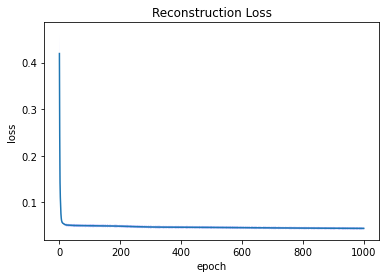

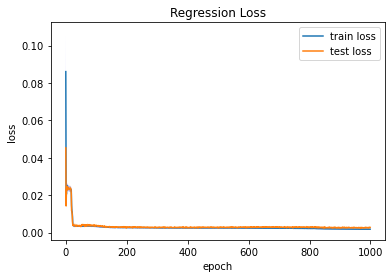

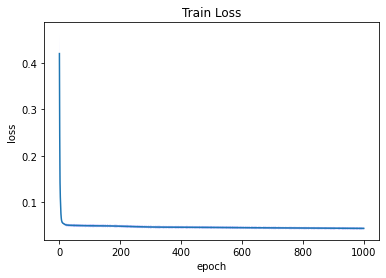

In [124]:
network.eval()
best_model.eval()

reconstruction_losses = np.array(reconstruction_losses)
reconstruction_losses_std = np.array(reconstruction_losses_std)
regression_losses = np.array(regression_losses)
regression_losses_std = np.array(regression_losses_std)
test_losses = np.array(test_losses)
test_losses_std = np.array(test_losses_std)
train_losses = np.array(train_losses)
train_losses_std = np.array(train_losses_std)

plt.plot(reconstruction_losses, '-')
plt.fill_between(range(len(reconstruction_losses)), reconstruction_losses-reconstruction_losses_std, reconstruction_losses+reconstruction_losses_std, facecolor='blue', alpha=0.3)
plt.title('Reconstruction Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(regression_losses, '-', label='train loss')
plt.fill_between(range(len(regression_losses)), regression_losses-regression_losses_std, regression_losses+regression_losses_std, facecolor='blue', alpha=0.3)
plt.plot(test_losses, '-', label='test loss')
plt.fill_between(range(len(test_losses)), test_losses-test_losses_std, test_losses+test_losses_std, facecolor='orange', alpha=0.3)
plt.title('Regression Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(train_losses, '-')
plt.fill_between(range(len(train_losses)), train_losses-train_losses_std, train_losses+train_losses_std, facecolor='blue', alpha=0.3)
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Evaluation

train loss=0.0017238056752830744


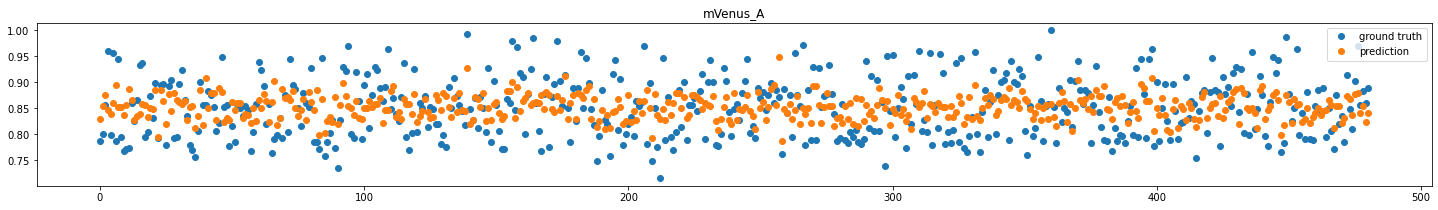

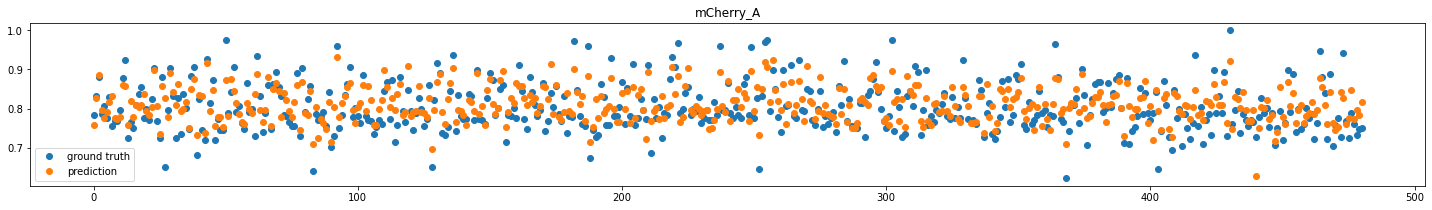

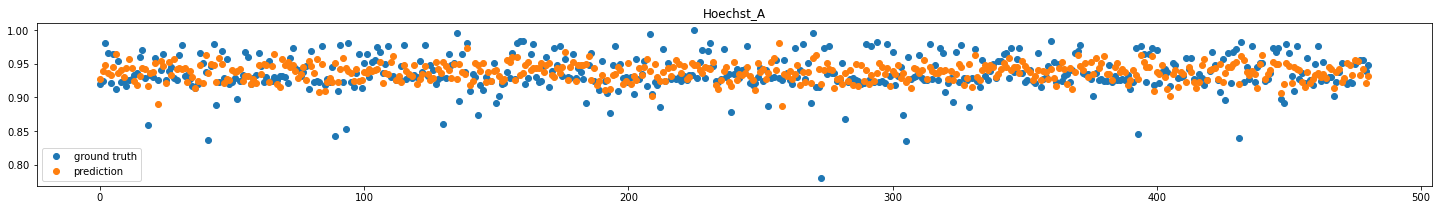

test loss=0.0026289571542292833


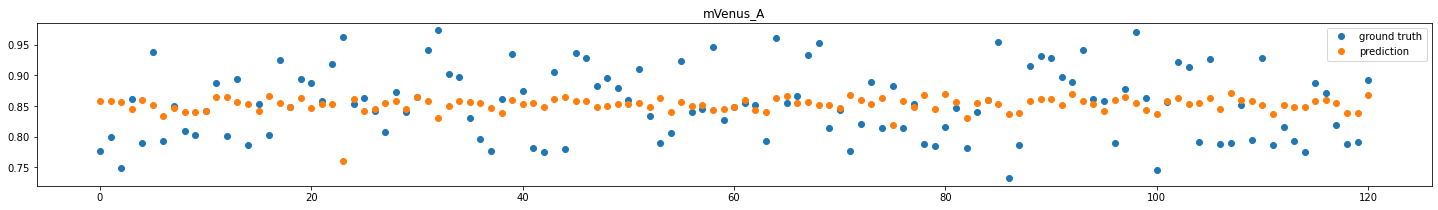

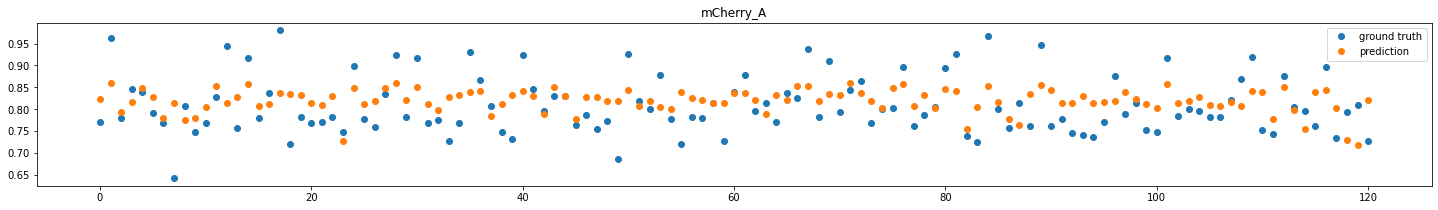

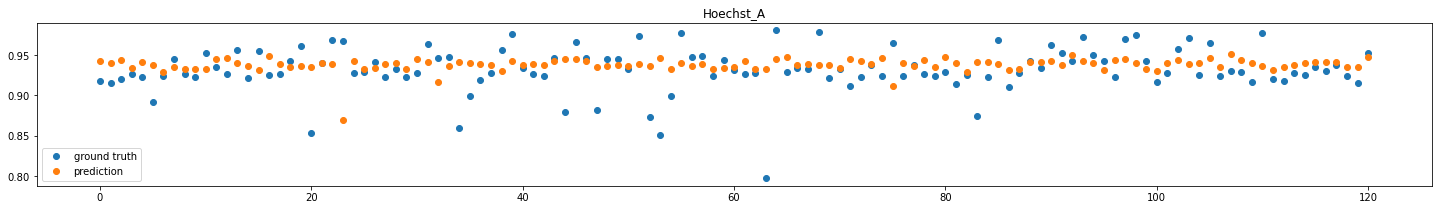

In [125]:
x, y = train_dataset[:]
x = x.to(device)
y = y.to(device)
_, _, pred = network(x)
y = y.cpu().detach()
pred = pred.cpu().detach()
train_loss = mse_loss(y, pred)

print('train loss={}'.format(train_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

x, y = test_dataset[:]
x = x.to(device)
y = y.to(device)
_, _, pred_test = network(x)
y = y.cpu().detach()
pred_test = pred_test.cpu().detach()
test_loss = mse_loss(y, pred_test)

print('test loss={}'.format(test_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred_test[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred_test[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred_test[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

train loss=0.0017696318682283163


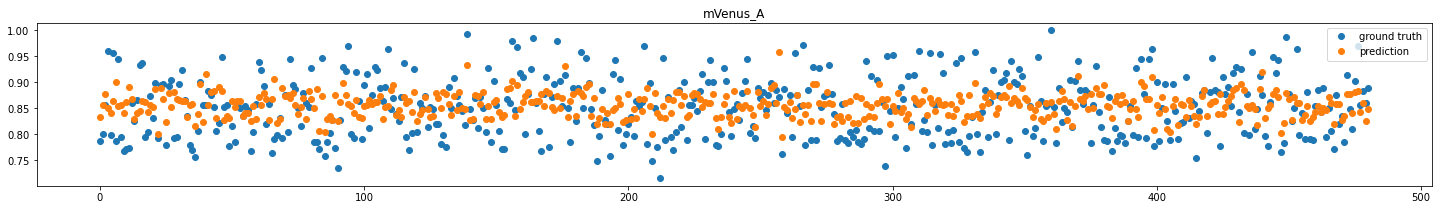

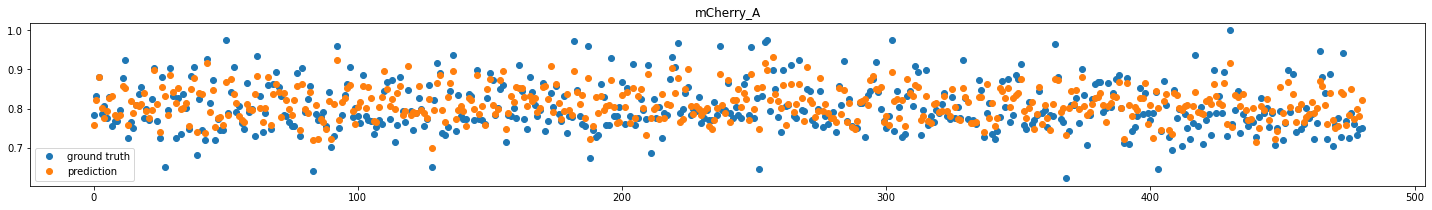

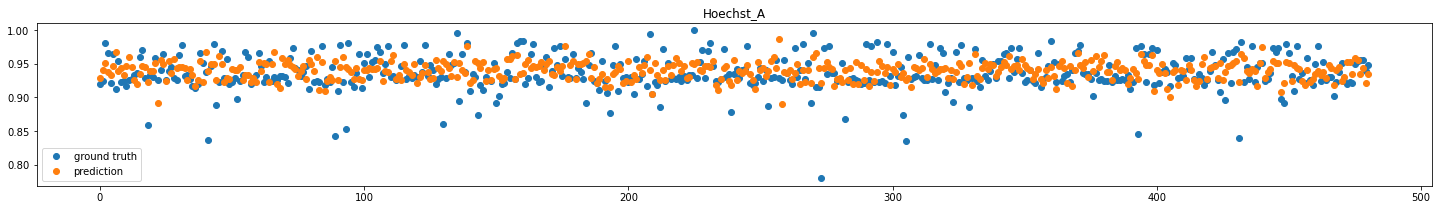

test loss=0.00263283122330904


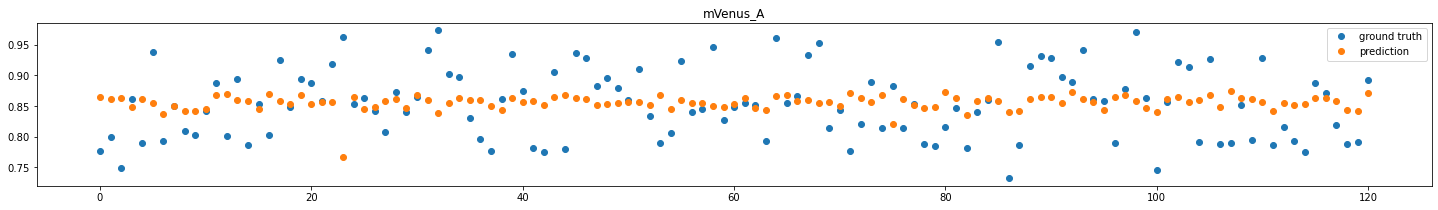

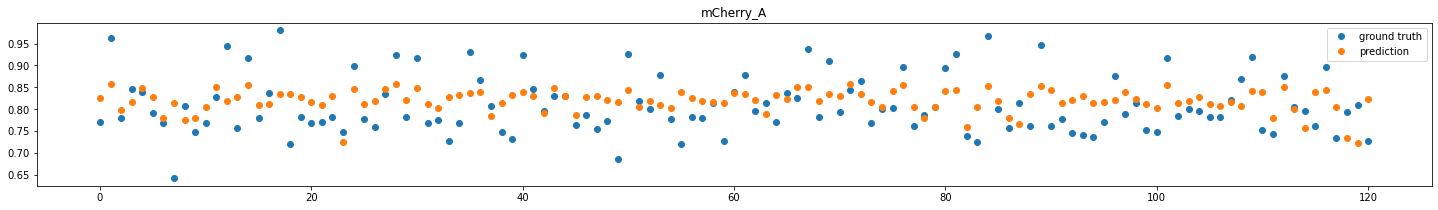

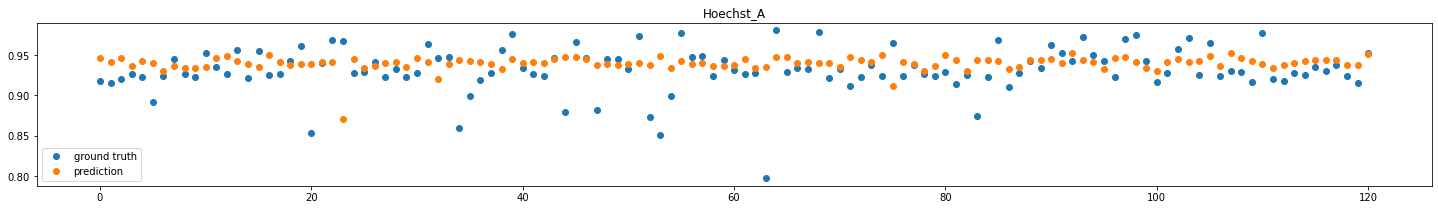

In [126]:
x, y = train_dataset[:]
x = x.to(device)
y = y.to(device)
_, _, pred = best_model(x)
y = y.cpu().detach()
pred = pred.cpu().detach()
train_loss = mse_loss(y, pred)

print('train loss={}'.format(train_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

x, y = test_dataset[:]
x = x.to(device)
y = y.to(device)
_, _, pred_test = best_model(x)
y = y.cpu().detach()
pred_test = pred_test.cpu().detach()
test_loss = mse_loss(y, pred_test)

print('test loss={}'.format(test_loss.item()))

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y[:, 0], 'o', label='ground truth')
plt.plot(pred_test[:, 0], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y[:, 1], 'o', label='ground truth')
plt.plot(pred_test[:, 1], 'o', label='prediction')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y[:, 2], 'o', label='ground truth')
plt.plot(pred_test[:, 2], 'o', label='prediction')
plt.legend()
plt.show()

In [127]:
#winsound.Beep(2500, 1000)